For writing the narrative and exporting data.

In [52]:
import pickle
import math
import json
import numpy as np
import matplotlib.pyplot as plt

CUNAME = 'Columbia University in the City of New York'

S_TOTALS = pickle.load(open('../data/S_Sex_Graduates.p', 'rb'))
E_TOTALS = pickle.load(open('../data/E_Sex_Graduates.p', 'rb'))
D_TOTALS = pickle.load(open('../data/SE-Detailed_Sex.p', 'rb'))

years = sorted(S_TOTALS.keys())
institutions = sorted(S_TOTALS[ max(years) ].keys())
fields = {
    'Science': set(),
    'Engineering': set()
}
for year in years:
    inst_stats = D_TOTALS[year]['Columbia University in the City of New York']
    for seh in inst_stats.keys():
        for field in inst_stats[seh].keys():
            fields[seh].add(field)
fields['Science'] = sorted(fields['Science'])
fields['Engineering'] = sorted(fields['Engineering'])

print(f'{len(institutions)} institutions and {len(fields["Science"]) + len(fields["Engineering"])} fields.')

11 institutions and 39 fields.


In [122]:
# Returns female and male headcounts for a field in an institution
def get_counts(seh, field, inst='Columbia University in the City of New York', default=None):
    females = []
    males = []
    for year in years:
        stats = D_TOTALS[year][inst][seh].get(field, None)
        if stats is None:
            females.append(default)
            males.append(default)
            continue
        females.append(stats.get('Female', 0))
        males.append(stats.get('Male', 0))
    return females, males


complete_fields = {
    'Science': [],
    'Engineering': [],
}
topic_lookup = {}
for topic in complete_fields.keys():
    for field in fields[topic]:
        f, m = get_counts(topic, field)
        if None not in f and None not in m:
            complete_fields[topic].append(field)
            topic_lookup[field] = topic
print(f'{len(complete_fields["Science"]) + len(complete_fields["Engineering"])} complete fields.')

19 complete fields.


In [195]:
# Convenient function for making subplots
def subplots(num=1, cols=2, figsize=6):
    if num < cols:
        cols = num
    rows = math.ceil(num / cols)
    return plt.subplots(rows, cols, figsize=(figsize * cols, figsize * rows))

# Gets female and male headcounts for a field in an institution
def get_counts(field, inst='Columbia University in the City of New York', default=None):
    females = []
    males = []
    topic = topic_lookup[field]
    for year in years:
        stats = D_TOTALS[year][inst][topic].get(field, None)
        if stats is None:
            females.append(default)
            males.append(default)
            continue
        females.append(stats.get('Female', 0))
        males.append(stats.get('Male', 0))
    return females, males

# Gets proportions for a field in an institution
def get_proportions(field, inst='Columbmia University in the City of New York'):
    females, males = get_counts(field, inst)
    proportions = []
    for i in range(len(years)):
        f, m = females[i], males[i]
        if f is None or m is None: 
            proportions.append(None)
        else:
            proportions.append(f / (m+f))
    return proportions

def plot_proportions(ax, field, inst='Columbia University in the City of New York', title=None, peers=False,
                     start=1994, label_line=True):
    proportions = get_proportions(field, inst)
    if peers:
        for inst in institutions:
            if inst != CUNAME:
                ax.plot(years, get_overall_proportions(topic, inst), color='lightgreen', linewidth=1)
    start_i = start - years[0]
    # ax.plot(years[:start_i + 1], proportions[:start_i + 1], color='lightgreen')
    ax.plot(years[start_i:], proportions[start_i:], color='green')
    if label_line: ax.annotate(field, (years[start_i], proportions[start_i]))
    ax.set_ylim(bottom=0, top=1)
    ax.set_title(title or field)

# Plots a female and male headcounts for a field
def plot_counts(ax, field, inst='Columbia University in the City of New York', title=None):
    females, males = get_counts(field, inst)
    ax.plot(years, females, label='Female')
    ax.plot(years, males, label='Male')
    ax.legend()
    ax.set_ylim(bottom=0)
    ax.set_title(title or field)
    ax.set_ylabel('Number of people')

def plot_connected(ax, field, inst='Columbia University in the City of New York', title=None):
    f, m = get_counts(field, inst, default=0)
    ax.plot(f, m, color='lightgray')
    ax.scatter(f, m, c=[i for i in range(len(m))], cmap='viridis')
    for i in [0, -1]:
        ax.annotate(years[i], (f[i], m[i]))
    _, ymax = ax.get_ylim()
    _, xmax = ax.get_xlim()
    top = max(ymax, xmax)    
    ax.set_ylim(bottom=0, top=top)
    ax.set_xlim(left=0, right=top)    
    ax.set_title(title or field)
    ax.plot([0, top], [0, top], color='gray', linestyle='--')
    ax.set_xlabel('Number of women')
    ax.set_ylabel('Number of men')

def plot_triplet(ax_ary, index, field):
    plot_proportions(ax_ary[index, 0], field)
    plot_counts(ax_ary[index, 1], field)
    plot_connected(ax_ary[index, 2], field)

# Gets overall counts from complete fields for an institution in a topic
def get_overall_counts(topic, inst='Columbia University in the City of New York'):
    overallF = [0 for _ in range(len(years))]
    overallM = [0 for _ in range(len(years))]
    counts = {field: get_counts(field, inst, default=0) for field in complete_fields[topic]}

    for field in complete_fields[topic]:
        f, m = counts[field]
        for i in range(len(years)):
            overallF[i] += f[i]
            overallM[i] += m[i]
    return overallF, overallM

# Gets overall proportions from overall counts
def get_overall_proportions(topic, inst='Columbia University in the City of New York'):
    overallF, overallM = get_overall_counts(topic, inst)
    return [0 if m+f == 0 else f/(m+f) for f, m in zip(overallF, overallM)]

# Plots proportions for a topic
def plot_topic_proportions(ax, topic, peers=False, title=None, label=[]):
    colors = ['blue', 'lightblue']
    if topic == 'Science':
        colors = ['red', 'pink']
    if peers:
        for inst in institutions:
            if inst != CUNAME:
                ax.plot(years, get_overall_proportions(topic, inst), color=colors[1], linewidth=1)
    cu_props = get_overall_proportions(topic, CUNAME)
    ax.plot(years, cu_props, color=colors[0], linewidth=2)
    for i in [0, -1] + [year - years[0] for year in label]:
        ax.annotate("{0:.0%}".format(cu_props[i]), (years[i], cu_props[i]))
    ax.set_ylim(bottom=0, top=1)
    ax.set_title(title or topic)

# Plots a female and male headcounts for a topic
def plot_topic_counts(ax, topic, inst='Columbia University in the City of New York', title=None):
    females, males = get_overall_counts(topic, inst)
    ax.plot(years, females, label='Female')
    ax.plot(years, males, label='Male')
    ax.legend()
    ax.set_ylim(bottom=0)
    ax.set_title(title or topic)
    ax.set_ylabel('Number of people')

def plot_topic_connected(ax, topic, inst='Columbia University in the City of New York', title=None):
    f, m = get_overall_counts(topic, inst)
    ax.plot(f, m, color='lightgray')
    ax.scatter(f, m, c=[i for i in range(len(m))], cmap='viridis')
    for i in [0, -1]:
        ax.annotate(years[i], (f[i], m[i]))
    _, ymax = ax.get_ylim()
    _, xmax = ax.get_xlim()
    top = max(ymax, xmax)    
    ax.set_ylim(bottom=0, top=top)
    ax.set_xlim(left=0, right=top)    
    ax.set_title(title or topic)
    ax.plot([0, top], [0, top], color='gray', linestyle='--')
    ax.set_xlabel('Number of women')
    ax.set_ylabel('Number of men')

# Lede

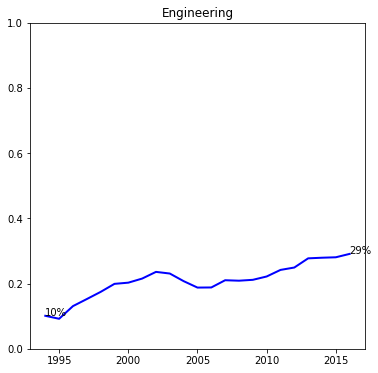

In [182]:
_, ax = subplots()
plot_topic_proportions(ax, 'Engineering')

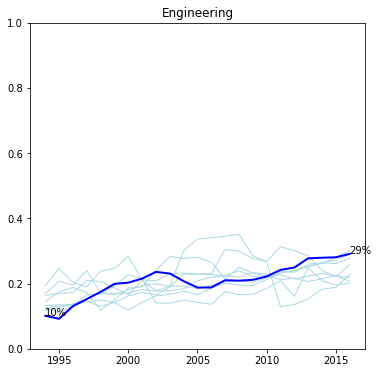

In [184]:
_, ax = subplots()
plot_topic_proportions(ax, 'Engineering', peers=True)

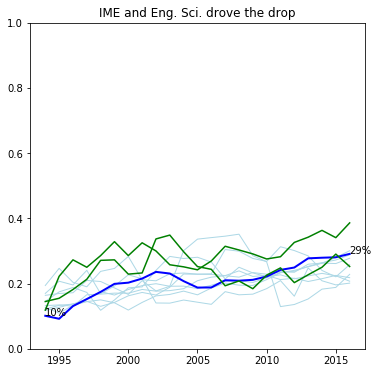

In [191]:
_, ax = subplots()
plot_topic_proportions(ax, 'Engineering', peers=True)
plot_proportions(ax, 'Engineering science, mechanics, and physics', label_line=False)
plot_proportions(ax, 'Industrial and manufacturing engineering', label_line=False, 
                 title='IME and Eng. Sci. drove the drop')

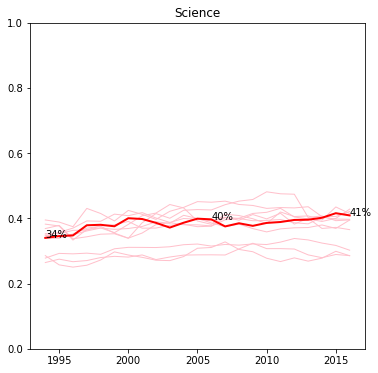

In [158]:
_, ax = subplots()
plot_topic_proportions(ax, 'Science', peers=True, label=[2006])

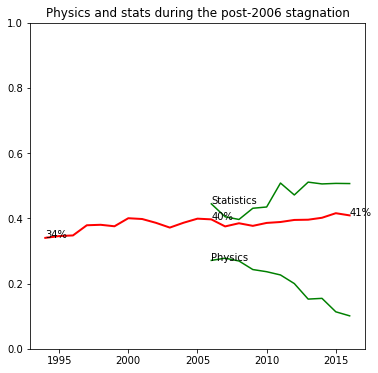

In [181]:
_, ax = subplots()
plot_proportions(ax, 'Physics', start=2006)
plot_proportions(ax, 'Statistics', start=2006)
plot_topic_proportions(ax, 'Science', label=[2006],
                       title='Physics and stats during the post-2006 stagnation')

## Closer look at Engineering

Rise after 2006 lies primarily in Industrial and Manufacturing Engineering, marginal help from Engineering Science, Mechanics, and Physics. Electrical Engineering and Mechanical Engineering were left behind.

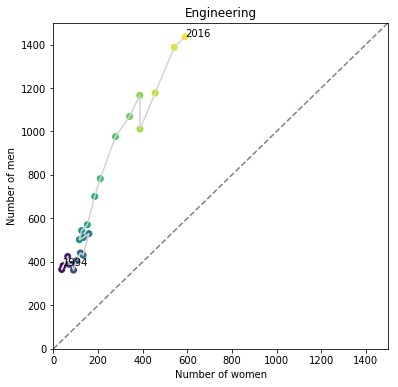

In [199]:
_, ax = subplots()
plot_topic_connected(ax, 'Engineering')

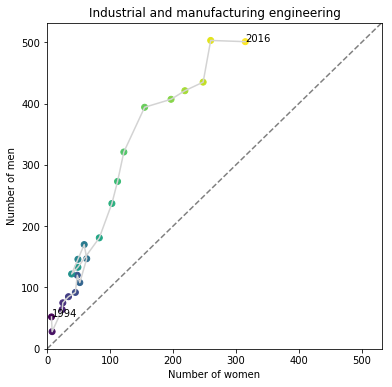

In [201]:
_, ax = subplots()
plot_connected(ax, 'Industrial and manufacturing engineering')

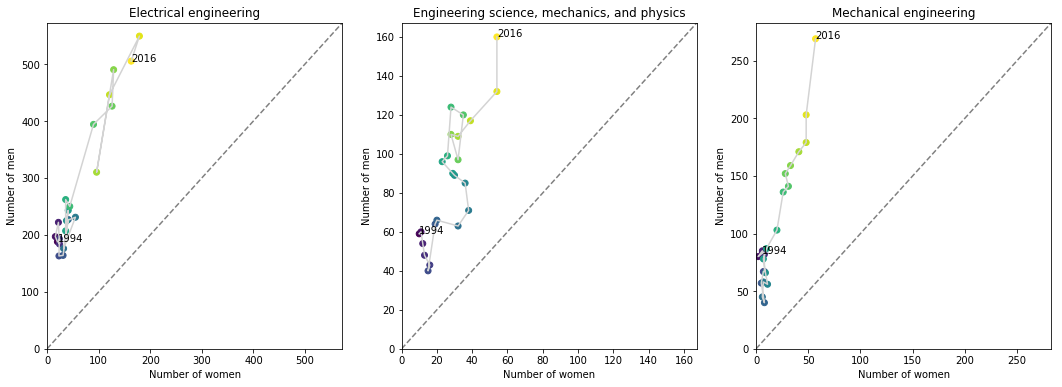

In [203]:
selected = [f for f in complete_fields['Engineering'] if f != 'Industrial and manufacturing engineering']
_, ax = subplots(3, cols=3)
for i, field in enumerate(selected):
    plot_connected(ax[i], field)

## Closer look at Science

Female strong: geosciences, anthropology

Constant: anthropology, biology, chemistry, sociology, **statistics**
    
Converging: **math and applied math**

Diverging: **computer science**, **physics**

_Too small or sketchy data: astronomy and astrophysics, microbiology, nutrition, pharmacology, physiology, economics_

Notice: math and applied math and physics mirror each other until 2012

Idea: In lede, after showing overall science, reveal that the steady incline is extremely distorting. Show these trends after and including 2006: physics going from 30% to 10%, but then statistics or anthropology.